<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/08_pytorch_replicando_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os

NUM_WORKERS= os.cpu_count()

#### 0. Codigos com importacoes e download de dados de sempre

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Conseguindo dados

Os mesmos dados pizza, steak, sushi.

Baixado com a funcao `donwload_data()` criada no modulo anterior

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. TRansformandos em DataLoaders

### 2.1 Transforms

In [ ]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Transforms criado manualmente: {manual_transforms}")

Transforms criado manualmente: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Criando os dataloaders

In [ ]:
BATCH_SIZE = 32 #O paper usa 4096 de batch_size, mas pode ser muito grande para o hardware disponivel. Comecer pequeno

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d7348cdbe80>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualizando uma Imagem

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[5], label_batch[5]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

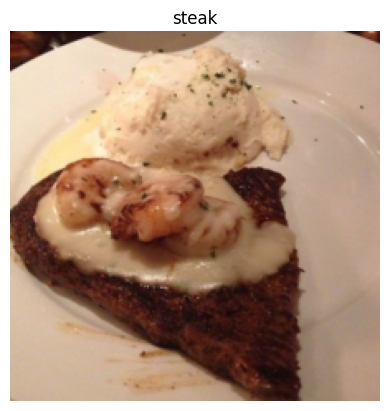

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicando ViT: Overview

Olhar para todo um paper de uma pesquisa de machine learn porde ser intimdidador, por isso e para tornar mais entendivel iremos quebrar em pequenas pecas:

* **Inputs** - O que entra no modelo? (Em nosso caso, imagens tensor)
* **Outputs** - O que sai do modelo/layer/block? (Em nosso caso, queremos que o modelo gere uma label de classificacao para imagens)
* **Blocks** - Uma colecao de layers
* **Model** - Uma colecao de blocks

### 3.1 ViT overview: Pecas do quebra cabeca:

* Figura 1: Visao geral do arquitetura
* Quatro equacoes: Equacoes matematicas que definem as funcoes de cada layer/bloco
* Table 1/3: Diferentes hyoerparametros para arquiteura/treinamento

### Figura 1:

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = Learnable representation(Comeca com valores aleatorios e melhorar atraves do tempo)

### Quatro Equacoes

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)



### Tabela 1:

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large e ViT-huge sao os diferentes tamanhado para os mesmo modelo de arquitetura da ViT.
* Layers - O numero de camadas de *Transformer encoder*
* Hidden size $D$ - O tamanho do *embedding* ao longo da arquitetura
* MLP size - O numero de hidden untis/neuronios na MLP (Perpecton multi-camadas)
* Head - O numero de *Multi head self-attention*